# Setup

Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, MaxPooling2D, Flatten

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *

Num GPUs Available:  0


Define some paths and constants.

In [2]:
# Paths
DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

# Preparing precipitation data

**Dataset**: RhiresD, which is a gridded daily precipitation dataset over Switzerland provided by MeteoSwiss. It is based on a spatial interpolation of rain-gauge data. The grid resolution is 1 km, but the effective resolution is in the order of 15-20 km.


**Aggregations levels**: The gridded dataset has been averaged over different regions:
* 12 climatic regions
* 5 aggregated regions
* the whole country

In [3]:
# Read precipitation file
df_prec = get_precipitation_data(DATADIR + '/MeteoSwiss/precip_regions.csv',
                                 DATE_START, DATE_END)

df_prec = prepare_prec_data_by_aggregated_regions(df_prec, qt=0.95)
prec_cols = df_prec.columns[1:7]
prec_xtr_cols = df_prec.columns[7:13]

# There are differences between climatic regions
df_prec.describe(exclude='datetime')

,reg_1,reg_2,reg_3,reg_4,reg_5,reg_tot,reg_1_xtr,reg_2_xtr,reg_3_xtr,reg_4_xtr,reg_5_xtr,reg_tot_xtr
count,15341.000000,15341.000000,15341.000000,15341.000000,15341.000000,15341.000000,15341,15341,15341,15341,15341,15341
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,14574,14575,14574,14574,14574,14574
mean,3.273633,4.040435,4.004187,3.219255,4.811217,3.787334,NaN,NaN,NaN,NaN,NaN,NaN
std,5.828022,6.904047,7.403110,7.074260,12.056366,6.251840,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.008000,0.013000,0.005000,0.004000,0.002000,0.025000,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.392000,0.714000,0.498000,0.401000,0.230000,0.951000,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.219000,5.399000,4.867000,3.066000,3.395000,5.019000,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Select regions of interest for following analyses (for example only 'reg_tot' or all sub-regions)
regions = ['reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5', 'reg_tot']
regions_xtr = ['reg_1_xtr', 'reg_2_xtr', 'reg_3_xtr', 'reg_4_xtr', 'reg_5_xtr', 'reg_tot_xtr']

# Analysis 1: ANN - Using time series of mean variable values over Switzerland as input

Objective: compare with previous analyses.

## Preparing input data (predictors)

In [5]:
# Read input files
l_files = glob.glob(os.path.join(DATADIR, 'ERA5', 'TS_CH', 'regions', 'df*.csv'))
l_files.append(os.path.join(DATADIR, 'ERA5', 'PCdf.csv'))
df_vars = read_csv_files(l_files, DATE_START, DATE_END, rename_columns=True)
df_vars = df_vars.drop(columns=list(df_vars.filter(regex='MSL')))

df_vars.shape

(15341, 43)

In [6]:
# Split set into training and testing based on dates
X_train_full = df_vars[(df_vars.date.dt.year >= YY_TRAIN[0]) &
                       (df_vars.date.dt.year <= YY_TRAIN[1])]
X_test = df_vars[(df_vars.date.dt.year >= YY_TEST[0]) &
                 (df_vars.date.dt.year <= YY_TEST[1])]
y_train_full = df_prec[(df_prec.date.dt.year >= YY_TRAIN[0]) &
                       (df_prec.date.dt.year <= YY_TRAIN[1])]
y_test = df_prec[(df_prec.date.dt.year >= YY_TEST[0]) &
                 (df_prec.date.dt.year <= YY_TEST[1])]

# Drop dates column
X_train_full = X_train_full.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

# Split full training into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42)

In [7]:
# Transform data
num_attribs = list(X_train)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
])

X_train = full_pipeline.fit_transform(X_train)
X_valid = full_pipeline.transform(X_valid)
X_test = full_pipeline.transform(X_test)

In [8]:
X_train.shape

(10135, 42)

## Prediction of precipitation **values**

In [9]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using timeseries to predict precipitation
ann_prec_v1 = keras.models.Sequential([
    Input(shape=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(regions), activation='relu')
])

ann_prec_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2752      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 7,302
Trainable params: 7,302
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile model and train
ann_prec_v1.compile(loss='mse',
                    optimizer='adam')

history = ann_prec_v1.fit(X_train, y_train[regions], epochs=50,
                          validation_data=(X_valid, y_valid[regions]))

Epoch 1/50
317/317 [==============================] - 1s 2ms/step - loss: 51.7802 - val_loss: 43.2753
Epoch 2/50
317/317 [==============================] - 0s 1ms/step - loss: 42.9838 - val_loss: 40.2382
Epoch 3/50
317/317 [==============================] - 0s 1ms/step - loss: 41.5072 - val_loss: 39.4866
Epoch 4/50
317/317 [==============================] - 0s 1ms/step - loss: 40.1184 - val_loss: 37.7518
Epoch 5/50
317/317 [==============================] - 0s 2ms/step - loss: 39.3521 - val_loss: 37.3451
Epoch 6/50
317/317 [==============================] - 0s 2ms/step - loss: 38.9768 - val_loss: 37.0601
Epoch 7/50
317/317 [==============================] - 1s 2ms/step - loss: 37.9368 - val_loss: 36.1667
Epoch 8/50
317/317 [==============================] - 0s 1ms/step - loss: 38.0690 - val_loss: 35.9309
Epoch 9/50
317/317 [==============================] - 0s 1ms/step - loss: 37.8589 - val_loss: 36.0705
Epoch 10/50
317/317 [==============================] - 0s 1ms/step - loss: 36.8815

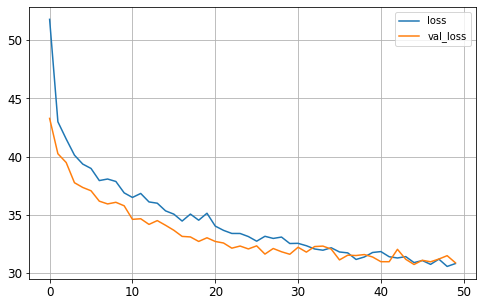

In [11]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [12]:
# Average score
test_mse = ann_prec_v1.evaluate(X_test, y_test[regions])
print(f'Test average MSE: {test_mse:.2f}')
print(f'Test average RMSE: {math.sqrt(test_mse):.2f}')

58/58 [==============================] - 0s 930us/step - loss: 28.1268
Test average MSE: 28.13
Test average RMSE: 5.30


In [13]:
# Scores per region
y_pred_train = ann_prec_v1.predict(X_train)
y_pred_test = ann_prec_v1.predict(X_test)

scores_train = np.sqrt(np.square(np.subtract(y_train[regions], y_pred_train)).mean())
scores_train.name = 'RMSE train'
scores_test = np.sqrt(np.square(np.subtract(y_test[regions], y_pred_test)).mean())
scores_test.name = 'RMSE test'

scores = pd.concat([scores_train, scores_test], axis=1)
print(scores.to_markdown())

|         |   RMSE train |   RMSE test |
|:--------|-------------:|------------:|
| reg_1   |      4.42167 |     4.05064 |
| reg_2   |      5.00142 |     5.03252 |
| reg_3   |      5.2954  |     5.14334 |
| reg_4   |      4.87092 |     5.19506 |
| reg_5   |      7.36103 |     7.54528 |
| reg_tot |      4.05534 |     4.08077 |


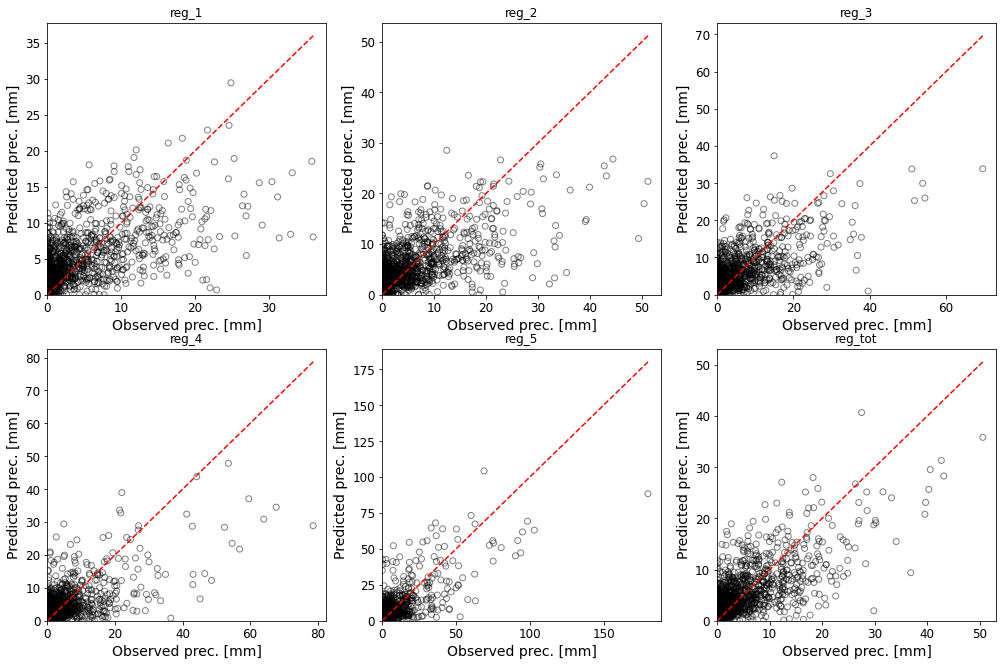

In [14]:
# Scatter plot of the predictions vs observations
plot_prediction_scatter(y_test[regions], y_pred_test)

## Prediction of precipitation **extremes**

In [15]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using timeseries to predict precipitation
ann_xtrm_v1 = keras.models.Sequential([
    Input(shape=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(len(regions_xtr), activation='sigmoid')
])

# Compile model and train (weight: tradeoff between recall and precision)
ann_xtrm_v1.compile(
    optimizer='adam',
    loss=WeightedBinaryCrossEntropy(
        pos_weight=5,
        weight=1,
        from_logits=False,
    )
)

history = ann_xtrm_v1.fit(X_train, y_train[regions_xtr].astype(float), epochs=50,
                          validation_data=(X_valid, y_valid[regions_xtr].astype(float)))


Epoch 1/50
317/317 [==============================] - 1s 2ms/step - loss: 0.4534 - val_loss: 0.3757
Epoch 2/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3679 - val_loss: 0.3488
Epoch 3/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3478 - val_loss: 0.3307
Epoch 4/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3363 - val_loss: 0.3182
Epoch 5/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3305 - val_loss: 0.3161
Epoch 6/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3249 - val_loss: 0.3150
Epoch 7/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3196 - val_loss: 0.3082
Epoch 8/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3132 - val_loss: 0.3080
Epoch 9/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3091 - val_loss: 0.3079
Epoch 10/50
317/317 [==============================] - 0s 1ms/step - loss: 0.3096 - val_loss: 0.3058

In [16]:
# Predict and evaluate the extremes
y_pred_train = ann_xtrm_v1.predict(X_train)
y_pred_test = ann_xtrm_v1.predict(X_test)

y_pred_train_bool = y_pred_train >= 0.5
y_pred_test_bool = y_pred_test >= 0.5

# Confusion matrix per region (x: prediction; y: true value)
# [[TN, FP] 
# [ FN, TP]]
for idx, region in enumerate(regions_xtr):
    cnf_matrix = confusion_matrix(y_test[region], y_pred_test_bool[:, idx])
    print(f"Confusion matrix {region}:\n {cnf_matrix}")

Confusion matrix reg_1_xtr:
 [[1684   62]
 [  54   27]]
Confusion matrix reg_2_xtr:
 [[1685   46]
 [  55   41]]
Confusion matrix reg_3_xtr:
 [[1691   51]
 [  46   39]]
Confusion matrix reg_4_xtr:
 [[1697   36]
 [  52   42]]
Confusion matrix reg_5_xtr:
 [[1712   32]
 [  35   48]]
Confusion matrix reg_tot_xtr:
 [[1690   55]
 [  33   49]]


Recall Baseline: 1.0 Test: 0.6 Train: 0.62
Precision Baseline: 0.04 Test: 0.47 Train: 0.52
Roc Baseline: 0.5 Test: 0.93 Train: 0.95


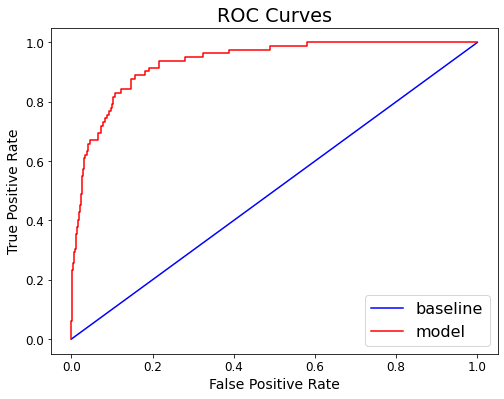

In [17]:
# Results for the whole country
# - Recall = TruePositives / (TruePositives + FalseNegatives); best = 1
# - Precision = TruePositives / (TruePositives + FalsePositives); best = 1
evaluate_model(y_test.reg_tot_xtr, y_train.reg_tot_xtr, y_pred_test_bool[:, -1],
                y_pred_test[:, -1], y_pred_train_bool[:, -1], y_pred_train[:, -1])

#  Analysis 2: ANN - Using gridded data over a larger domain as input

Objective: get some spatial information

## Preparing input data (predictors)

In [18]:
# Grid options (total extent: 80° lon & 50° lat)
resolution = 1
nb_lat = 20 * 1/resolution + 1
nb_lon = 30 * 1/resolution + 1

In [19]:
# Load gridded data
ds_z = get_era5_data(DATADIR + '/ERA5/geopotential/*.nc', DATE_START, DATE_END)
z = extract_points_around_CH(ds_z, step_lat=resolution, step_lon=resolution, nb_lat=nb_lat, nb_lon=nb_lon, levels=[300, 500, 700, 850, 1000])
ds_t2m = get_era5_data(DATADIR + '/ERA5/Daymean_era5_T2M_EU_19790101-20210905.nc', DATE_START, DATE_END)
t2m = extract_points_around_CH(ds_t2m, step_lat=resolution, step_lon=resolution, nb_lat=nb_lat, nb_lon=nb_lon)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [20]:
# We have arrays of 2D fields ...
t2m.dims

Frozen({'time': 15341, 'lon': 31, 'lat': 21})

In [21]:
# ... as well as arrays of 3D fields (with pressure levels)
z.dims

Frozen({'time': 15341, 'lon': 31, 'lat': 21, 'level': 5})

In [22]:
# Add a level dimension to the 2D dataset
t2m = t2m.expand_dims('level', axis=1)

In [23]:
# Split set into (training + validation) and testing based on dates
z_train_full = z.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
z_test = z.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))
t2m_train_full = t2m.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
t2m_test = t2m.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))

In [24]:
# Transform to numpy arrays and concatenate (takes time as it needs to load data from files)
X_train_full = np.concatenate((np.squeeze(z_train_full.to_array().to_numpy(), axis=0),
                               np.squeeze(t2m_train_full.to_array().to_numpy(), axis=0)), axis=1)
X_test = np.concatenate((np.squeeze(z_test.to_array().to_numpy(), axis=0),
                         np.squeeze(t2m_test.to_array().to_numpy(), axis=0)), axis=1)

X_train_full.shape

(13514, 6, 21, 31)

In [25]:
# Split full training into training and validation sets (and shuffle)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [26]:
# Reshape arrays to 2D arrays for transformation
shape = X_train.shape
X_train_flat = X_train.reshape((X_train.shape[0], shape[1]*shape[2]*shape[3]))
X_valid_flat = X_valid.reshape((X_valid.shape[0], shape[1]*shape[2]*shape[3]))
X_test_flat = X_test.reshape((X_test.shape[0], shape[1]*shape[2]*shape[3]))

X_train_flat.shape

(10135, 3906)

In [27]:
# Transform data
num_attribs = X_train_flat.shape[1]
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, list(range(num_attribs))),
])

X_train_flat = full_pipeline.fit_transform(X_train_flat)
X_valid_flat = full_pipeline.transform(X_valid_flat)
X_test_flat = full_pipeline.transform(X_test_flat)

## Prediction of precipitation **values**

In [28]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using gridded data to predict precipitation
ann_prec_v2 = keras.models.Sequential([
    Input(shape=X_train_flat.shape[1]),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(regions), activation='relu')
])

ann_prec_v2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               500096    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 517,382
Trainable params: 517,382
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile model and train
ann_prec_v2.compile(loss='mse',
                    optimizer='adam')

history = ann_prec_v2.fit(X_train_flat, y_train[regions], epochs=50,
                          validation_data=(X_valid_flat, y_valid[regions]))

Epoch 1/50
317/317 [==============================] - 2s 5ms/step - loss: 49.9101 - val_loss: 41.0973
Epoch 2/50
317/317 [==============================] - 1s 4ms/step - loss: 39.8070 - val_loss: 37.2661
Epoch 3/50
317/317 [==============================] - 1s 4ms/step - loss: 35.6408 - val_loss: 31.9047
Epoch 4/50
317/317 [==============================] - 1s 5ms/step - loss: 34.7045 - val_loss: 30.6936
Epoch 5/50
317/317 [==============================] - 2s 5ms/step - loss: 33.2531 - val_loss: 29.6998
Epoch 6/50
317/317 [==============================] - 1s 4ms/step - loss: 33.3063 - val_loss: 25.7103
Epoch 7/50
317/317 [==============================] - 1s 4ms/step - loss: 31.5336 - val_loss: 27.3991
Epoch 8/50
317/317 [==============================] - 1s 4ms/step - loss: 30.7097 - val_loss: 25.9319
Epoch 9/50
317/317 [==============================] - 1s 4ms/step - loss: 29.9901 - val_loss: 26.6983
Epoch 10/50
317/317 [==============================] - 1s 4ms/step - loss: 29.9757

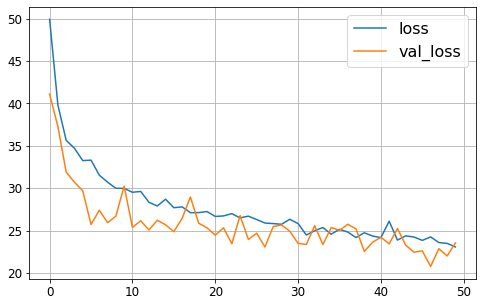

In [30]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [31]:
# Scores per region
y_pred_train = ann_prec_v2.predict(X_train_flat)
y_pred_test = ann_prec_v2.predict(X_test_flat)

scores_train = np.sqrt(np.square(np.subtract(y_train[regions], y_pred_train)).mean())
scores_train.name = 'RMSE train'
scores_test = np.sqrt(np.square(np.subtract(y_test[regions], y_pred_test)).mean())
scores_test.name = 'RMSE test'

scores = pd.concat([scores_train, scores_test], axis=1)
print(scores.to_markdown())

|         |   RMSE train |   RMSE test |
|:--------|-------------:|------------:|
| reg_1   |      4.00373 |     3.67498 |
| reg_2   |      4.30684 |     4.55267 |
| reg_3   |      4.67458 |     4.5926  |
| reg_4   |      3.98119 |     4.57799 |
| reg_5   |      5.87159 |     6.23633 |
| reg_tot |      3.35298 |     3.49897 |


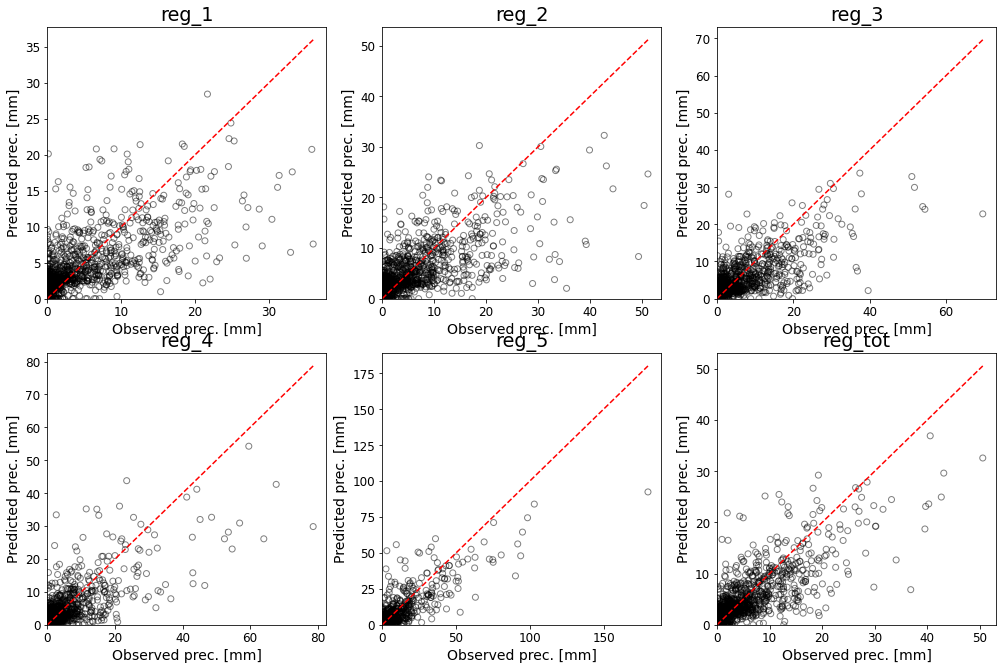

In [32]:
# Scatter plot of the predictions vs observations
plot_prediction_scatter(y_test[regions], y_pred_test)

## Prediction of precipitation **extremes**

In [33]:
# Clear session and set tf seed
from sklearn.utils import class_weight
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using gridded data to predict precipitation extremes
ann_xtrm_v2 = keras.models.Sequential([
    Input(shape=X_train_flat.shape[1]),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(regions_xtr), activation='sigmoid')
])

# Compile model and train
ann_xtrm_v2.compile(
    optimizer='adam',
    loss=WeightedBinaryCrossEntropy(
        pos_weight=5,
        weight=1,
        from_logits=False,
    )
)

history = ann_xtrm_v2.fit(X_train_flat, y_train[regions_xtr].astype(float), epochs=50,
                          validation_data=(X_valid_flat, y_valid[regions_xtr].astype(float)))


Epoch 1/50
317/317 [==============================] - 2s 3ms/step - loss: 0.5256 - val_loss: 0.3875
Epoch 2/50
317/317 [==============================] - 1s 3ms/step - loss: 0.4043 - val_loss: 0.3420
Epoch 3/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3834 - val_loss: 0.3196
Epoch 4/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3572 - val_loss: 0.3266
Epoch 5/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3387 - val_loss: 0.3055
Epoch 6/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3253 - val_loss: 0.2884
Epoch 7/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3238 - val_loss: 0.2892
Epoch 8/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3124 - val_loss: 0.2782
Epoch 9/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3060 - val_loss: 0.2765
Epoch 10/50
317/317 [==============================] - 1s 3ms/step - loss: 0.3015 - val_loss: 0.2841

In [34]:
# Predict and evaluate the extremes
y_pred_train = ann_xtrm_v2.predict(X_train_flat)
y_pred_test = ann_xtrm_v2.predict(X_test_flat)

y_pred_train_bool = y_pred_train >= 0.5
y_pred_test_bool = y_pred_test >= 0.5

# Confusion matrix per region
for idx, region in enumerate(regions_xtr):
    cnf_matrix = confusion_matrix(y_test[region], y_pred_test_bool[:, idx])
    print(f"Confusion matrix {region}:\n {cnf_matrix}")

Confusion matrix reg_1_xtr:
 [[1691   55]
 [  44   37]]
Confusion matrix reg_2_xtr:
 [[1691   40]
 [  55   41]]
Confusion matrix reg_3_xtr:
 [[1706   36]
 [  49   36]]
Confusion matrix reg_4_xtr:
 [[1702   31]
 [  48   46]]
Confusion matrix reg_5_xtr:
 [[1723   21]
 [  38   45]]
Confusion matrix reg_tot_xtr:
 [[1695   50]
 [  33   49]]


Recall Baseline: 1.0 Test: 0.6 Train: 0.65
Precision Baseline: 0.04 Test: 0.49 Train: 0.59
Roc Baseline: 0.5 Test: 0.95 Train: 0.97


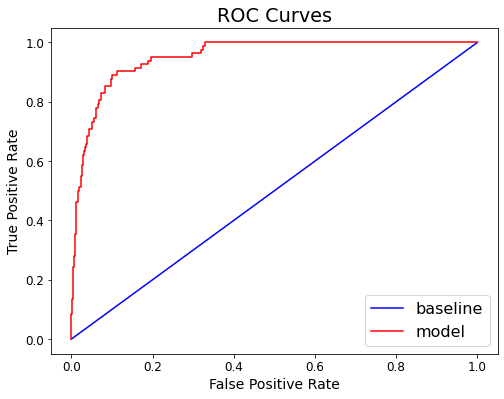

In [35]:
# Results for the whole country
evaluate_model(y_test.reg_tot_xtr, y_train.reg_tot_xtr, y_pred_test_bool[:, -1],
                y_pred_test[:, -1], y_pred_train_bool[:, -1], y_pred_train[:, -1])

#  Analysis 3: CNN - Using gridded data as input

Objective: better use spatial information

Data: same as previous analysis, but not flattened

## Preparing input data (predictors)

In [36]:
# Normalize data
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True)
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Reshape data (set channel first; Con2D option data_format='channels_first' does not work on Win 10 64 bit)
X_train = np.moveaxis(X_train, 1, -1)
X_valid = np.moveaxis(X_valid, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)

X_train.shape

(10135, 21, 31, 6)

## Prediction of precipitation **values**

In [37]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# CNN based on Davenport, F. V., & Diffenbaugh, N. S. (2021). Using Machine Learning 
# to Analyze Physical Causes of Climate Change: A Case Study of U.S. Midwest Extreme Precipitation. 
# Geophysical Research Letters, 48(15). https://doi.org/10.1029/2021GL093787
cnn_prec_v1 = keras.models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(regions), activation='relu'),
])

cnn_prec_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 31, 16)        880       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 15, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 560)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                17952     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [38]:
# Compile model and train
cnn_prec_v1.compile(loss='mse',
                    optimizer='adam')

history = cnn_prec_v1.fit(X_train, y_train.reg_tot, epochs=30,
                          validation_data=(X_valid, y_valid.reg_tot))

Epoch 1/30
317/317 [==============================] - 4s 12ms/step - loss: 29.9362 - val_loss: 21.5404
Epoch 2/30
317/317 [==============================] - 4s 13ms/step - loss: 22.4332 - val_loss: 18.0984
Epoch 3/30
317/317 [==============================] - 4s 14ms/step - loss: 20.6834 - val_loss: 17.5014
Epoch 4/30
317/317 [==============================] - 4s 12ms/step - loss: 18.8967 - val_loss: 15.7528
Epoch 5/30
317/317 [==============================] - 4s 12ms/step - loss: 18.2018 - val_loss: 15.6137
Epoch 6/30
317/317 [==============================] - 4s 12ms/step - loss: 17.2348 - val_loss: 14.6346
Epoch 7/30
317/317 [==============================] - 4s 12ms/step - loss: 16.7598 - val_loss: 15.4981
Epoch 8/30
317/317 [==============================] - 4s 12ms/step - loss: 16.1989 - val_loss: 15.4328
Epoch 9/30
317/317 [==============================] - 4s 12ms/step - loss: 15.6145 - val_loss: 14.4055
Epoch 10/30
317/317 [==============================] - 4s 12ms/step - los

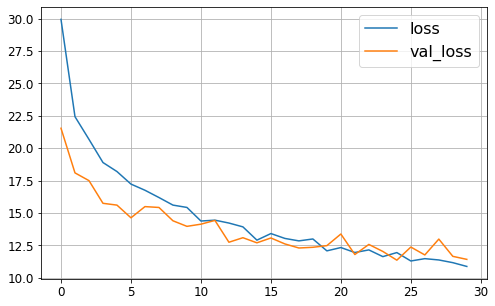

In [39]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [40]:
# Scores per region
y_pred = cnn_prec_v1.predict(X_test)
scores = np.sqrt(np.square(np.subtract(y_test[regions], y_pred)).mean())
scores.name = 'RMSE'
print(scores.to_markdown())

|         |    RMSE |
|:--------|--------:|
| reg_1   | 4.10999 |
| reg_2   | 4.48353 |
| reg_3   | 4.53497 |
| reg_4   | 4.80899 |
| reg_5   | 9.41725 |
| reg_tot | 3.31491 |


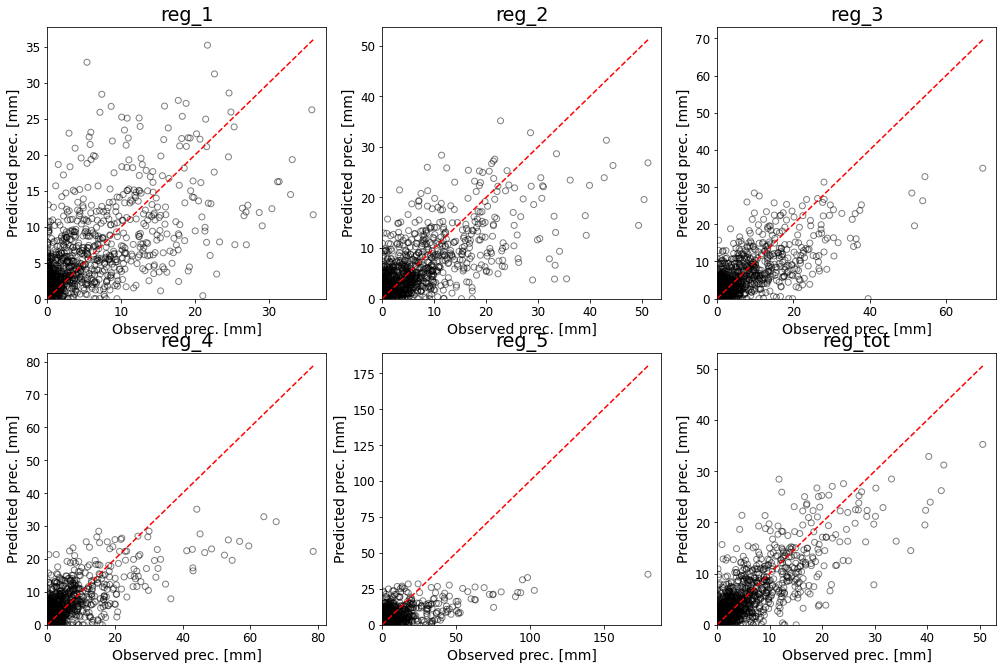

In [41]:
# Scatter plot of the predictions vs observations
plot_prediction_scatter(y_test[regions], y_pred)

## Prediction of precipitation **extremes**

In [42]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# ANN using timeseries to predict precipitation
cnn_xtrm_v1 = keras.models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(regions_xtr), activation='sigmoid')
])

# Compile model and train
cnn_xtrm_v1.compile(
    optimizer='adam',
    loss=WeightedBinaryCrossEntropy(
        pos_weight=5,
        weight=1,
        from_logits=False,
    )
)

history = cnn_xtrm_v1.fit(X_train, y_train[regions_xtr].astype(float), epochs=30,
                          validation_data=(X_valid, y_valid[regions_xtr].astype(float)))

Epoch 1/30
317/317 [==============================] - 4s 12ms/step - loss: 0.4151 - val_loss: 0.3433
Epoch 2/30
317/317 [==============================] - 4s 13ms/step - loss: 0.3508 - val_loss: 0.3164
Epoch 3/30
317/317 [==============================] - 4s 12ms/step - loss: 0.3296 - val_loss: 0.3031
Epoch 4/30
317/317 [==============================] - 4s 12ms/step - loss: 0.3096 - val_loss: 0.2739
Epoch 5/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2903 - val_loss: 0.2687
Epoch 6/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2851 - val_loss: 0.2681
Epoch 7/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2771 - val_loss: 0.2597
Epoch 8/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2699 - val_loss: 0.2682
Epoch 9/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2658 - val_loss: 0.2611
Epoch 10/30
317/317 [==============================] - 4s 12ms/step - loss: 0.2603 - val_lo

In [43]:
# Predict and evaluate the extremes
y_pred_train = cnn_xtrm_v1.predict(X_train)
y_pred_test = cnn_xtrm_v1.predict(X_test)

y_pred_train_bool = y_pred_train >= 0.5
y_pred_test_bool = y_pred_test >= 0.5

# Confusion matrix per region (x: prediction; y: true value)
for idx, region in enumerate(regions_xtr):
    cnf_matrix = confusion_matrix(y_test[region], y_pred_test_bool[:, idx])
    print(f"Confusion matrix {region}:\n {cnf_matrix}")

Confusion matrix reg_1_xtr:
 [[1700   46]
 [  43   38]]
Confusion matrix reg_2_xtr:
 [[1677   54]
 [  51   45]]
Confusion matrix reg_3_xtr:
 [[1659   83]
 [  39   46]]
Confusion matrix reg_4_xtr:
 [[1701   32]
 [  48   46]]
Confusion matrix reg_5_xtr:
 [[1695   49]
 [  19   64]]
Confusion matrix reg_tot_xtr:
 [[1670   75]
 [  26   56]]


Recall Baseline: 1.0 Test: 0.68 Train: 0.83
Precision Baseline: 0.04 Test: 0.43 Train: 0.59
Roc Baseline: 0.5 Test: 0.95 Train: 0.98


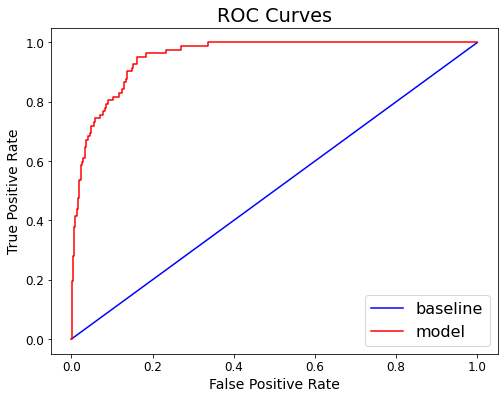

In [44]:
# Results for the whole country
evaluate_model(y_test.reg_tot_xtr, y_train.reg_tot_xtr, y_pred_test_bool[:, -1],
                y_pred_test[:, -1], y_pred_train_bool[:, -1], y_pred_train[:, -1])